In [98]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
pd.set_option('display.max_rows', 500)
from sklearn.model_selection import train_test_split
import time
import math
pd.options.mode.copy_on_write = True 
import datetime

In [99]:
df_lane = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\Lane_shipment_data.xlsx')
df_lane.head()

,date,week,year,month,Lane,shipment
0,2021-12-20,51,2021,12,DE02_29080846,1
1,2022-03-21,12,2022,3,DE02_29080846,1
2,2020-01-06,2,2020,1,DE02_29080846,0
3,2020-01-13,3,2020,1,DE02_29080846,0
4,2020-01-20,4,2020,1,DE02_29080846,0


In [100]:
df_holiday = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\holiday sheet.xlsx')
df_holiday.head()

,year,week,Holiday Flag
0,2020,1,1
1,2020,15,1
2,2020,17,1
3,2020,18,1
4,2020,21,1


In [101]:
df_holiday.dtypes

year            int64
week            int64
Holiday Flag    int64
dtype: object

# Data Preprocessing

In [9]:
def data_preprocessing(df_lane, df_holiday):
    final_data = pd.merge(df_lane, df_holiday, on=['year', 'week'], how='left')
    #fill Nan value with 0 in holiday_flag
    final_data['Holiday Flag'] = final_data['Holiday Flag'].fillna(0)
    final_data['Holiday Flag'] = final_data['Holiday Flag'].astype(np.int64)


    final_data['Quarter'] = final_data['date'].dt.quarter
    final_data['Quarter'] = final_data['Quarter'].astype(np.int64)

    # Lag features
    final_data['Previous Week Shipment'] = final_data['shipment'].shift(1)
    final_data['Previous Year Shipment'] = final_data.groupby(['Lane'])['shipment'].shift(52)

    #Filling Nan values in Lag Feature

    final_data['Previous Year Shipment'] = final_data['Previous Year Shipment'].interpolate()
    final_data['Previous Year Shipment'] = final_data['Previous Year Shipment'].fillna(0)
    final_data['Previous Week Shipment'] = final_data['Previous Week Shipment'].fillna(0)
    
    
    # Historical trends
    final_data['Moving Average Shipment'] = final_data.groupby(['Lane'])['shipment'].rolling(window=4).mean().reset_index(drop=True)
    final_data['Moving Average Shipment'] = final_data['Moving Average Shipment'].fillna(0) 

    # Convert created features to integer
    final_data['Previous Week Shipment'] = final_data['Previous Week Shipment'].astype(np.int64)
    final_data['Previous Year Shipment'] = final_data['Previous Year Shipment'].astype(np.int64)
    final_data['Moving Average Shipment'] = final_data['Moving Average Shipment'].astype(np.int64)

    return final_data
    
    

In [10]:
final_data = data_preprocessing(df_lane, df_holiday)
final_data.head()

,date,week,year,month,Lane,shipment,Holiday Flag,Quarter,Previous Week Shipment,Previous Year Shipment,Moving Average Shipment
0,2021-12-20,51,2021,12,DE02_29080846,1,1,4,0,0,0
1,2022-03-21,12,2022,3,DE02_29080846,1,0,1,1,0,0
2,2020-01-06,2,2020,1,DE02_29080846,0,0,1,1,0,0
3,2020-01-13,3,2020,1,DE02_29080846,0,0,1,0,0,0
4,2020-01-20,4,2020,1,DE02_29080846,0,0,1,0,0,0


In [11]:
import json
def top20Lane_selection(final_data):
    week_count = pd.DataFrame(columns = ['Lane','Count'])
    lan = []
    count = []

    top_lanes= final_data[(final_data['year']==2023) & final_data['shipment']!=0]
    for lane in top_lanes['Lane'].unique():
        cnt = top_lanes[top_lanes['Lane']==lane]['date'].nunique()
        lan.append(lane)
        count.append(cnt)

    week_count['Lane'] = lan
    week_count['Count'] = count

    lanes_week_wise = list(week_count.sort_values('Count', ascending = False)[:30]['Lane'].unique())

    top20_Lanes = final_data[final_data['Lane'].isin(lanes_week_wise)].reset_index(drop=True)
    top20_Lanes = top20_Lanes.groupby(['Lane','year'])['shipment'].sum().reset_index()
    top20_Lanes = top20_Lanes[top20_Lanes['year']==2023]
    top20_Lanes = list(top20_Lanes.sort_values('shipment', ascending = False)[:20]['Lane'].unique())

    top20_df = final_data[final_data['Lane'].isin(top20_Lanes)].reset_index(drop=True)

    # Save the label mapping as JSON file
    with open('lane_enocoded_labels.json', 'r') as json_file:
        label_mapping = json.load(json_file)

    
    top20_df['Encoded_Lane'] = top20_df['Lane'].map(label_mapping)

    return top20_df


    

In [15]:
top20_df = top20Lane_selection(final_data)
top20_df.shape

(4160, 12)

In [16]:
top20_df.head()

,date,week,year,month,Lane,shipment,Holiday Flag,Quarter,Previous Week Shipment,Previous Year Shipment,Moving Average Shipment,Encoded_Lane
0,2023-01-09,2,2023,1,DE02_29143519,1,0,1,0,1,0,1
1,2023-01-16,3,2023,1,DE02_29143519,1,0,1,1,1,0,1
2,2023-01-02,1,2023,1,DE02_29143519,0,1,1,1,1,0,1
3,2023-01-23,4,2023,1,DE02_29143519,0,0,1,0,1,0,1
4,2023-01-30,5,2023,1,DE02_29143519,0,0,1,0,1,0,1


(array([2.917e+03, 7.240e+02, 3.740e+02, 6.900e+01, 2.800e+01, 2.900e+01,
        1.100e+01, 6.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

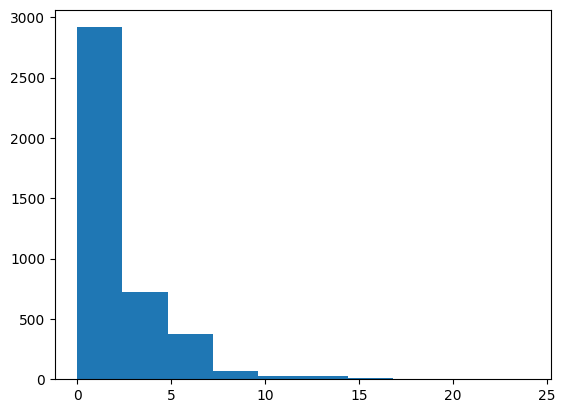

In [17]:
import matplotlib.pyplot as plt
plt.hist(top20_df['shipment'])

# Filtering Top20 Lanes

In [64]:
from scipy.special import boxcox, inv_boxcox

In [76]:
from scipy.special import boxcox, inv_boxcox

def data_tain_test_split(top20_df):

    # Box-cox transform
    top20_df['shipment_transformed']= boxcox(top20_df['shipment'],2.5)  # Adding 1 to avoid zero values
    


    #filter latest 8 weeks for testing the model
    test = top20_df[(top20_df['year'] == 2023) & (top20_df['week'] >= 45)].reset_index(drop=True)
    #train dataset except last 8 weeks
    train = top20_df.drop(index = test.index.tolist()).reset_index(drop=True)
    

    # #Square Root transform the target shipment column in both train and test
    # train['shipment_sqrt_transform'] = np.sqrt(train['shipment'])
    # test['shipment_sqrt_transform'] = np.sqrt(test['shipment'])

    X_train = train.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
    y_train = train['shipment_transformed']

    X_test = test.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
    y_test = test['shipment_transformed']

    return X_train, y_train, X_test, y_test, train, test, lambda_value


    

In [77]:
X_train, y_train, X_test, y_test, train, test, lambda_value = data_tain_test_split(top20_df)

(array([3.924e+03, 4.100e+01, 1.600e+01, 1.100e+01, 4.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-4.00000000e-01,  1.12472487e+02,  2.25344975e+02,  3.38217462e+02,
         4.51089949e+02,  5.63962437e+02,  6.76834924e+02,  7.89707411e+02,
         9.02579899e+02,  1.01545239e+03,  1.12832487e+03]),
 <BarContainer object of 10 artists>)

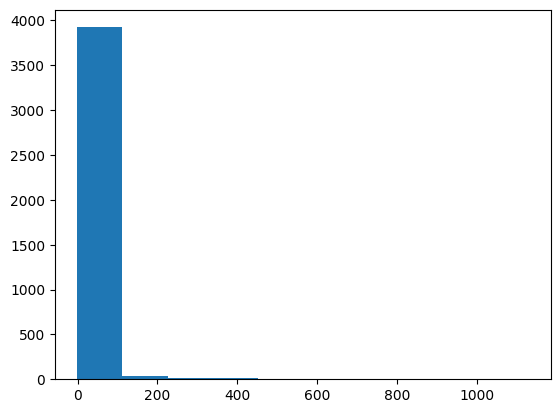

In [78]:
plt.hist(y_train)

(array([140.,  13.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ -0.4       ,  19.5532253 ,  39.50645061,  59.45967591,
         79.41290121,  99.36612652, 119.31935182, 139.27257712,
        159.22580243, 179.17902773, 199.13225303]),
 <BarContainer object of 10 artists>)

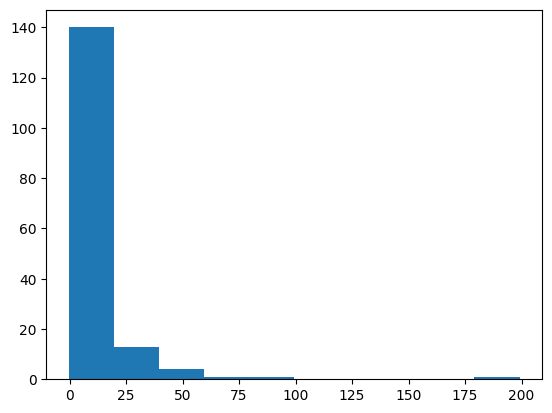

In [79]:
plt.hist(y_test)

# Model Building

In [80]:
import xgboost as xgb 

def XGB_model(X_train, y_train):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    return model

In [81]:
def model_training(model, X_train, y_train):
    if model == 'xgboost':
        model_xgb = XGB_model(X_train, y_train)

    return model_xgb

In [82]:
model_xgb = model_training('xgboost', X_train, y_train)

# Prediction

In [83]:
# Sample function to calculate WAPE
def weighted_absolute_percentage_error(y_true, y_pred):
    total_weight = sum(y_true)
    
    # Check if total_weight is zero to avoid division by zero
    if total_weight == 0:
        return None  # Return None to indicate no shipments
    
    absolute_errors = abs(y_true - y_pred)
    weighted_absolute_errors = absolute_errors * y_true
    wape = sum(weighted_absolute_errors) / total_weight * 100
    return wape

In [88]:

def predict_evaluate(model, X_test, y_test, lambda_value):
    # Predict
    y_pred = model.predict(X_test)
    #y_pred = np.expm1(y_pred)
        
    # Calculate WAPE score
    wape = weighted_absolute_percentage_error(y_test, y_pred)

    test['Predicted_shipment'] = inv_boxcox(y_pred, 2.5)
    test['Predicted_shipment'] = [round(x) for x in test['Predicted_shipment']]
    #test['Predicted_shipment'] = [round(x) for x in y_pred]
    test.head()
    
    return test, wape
    

In [89]:
predicted_df, wape = predict_evaluate(model_xgb, X_test, y_test, lambda_value)
wape

0.011108959982064836

In [97]:
predicted_df.to_csv('predicted_shipment_V4.csv', index = False)

(array([84., 31., 18.,  7.,  8.,  9.,  1.,  1.,  0.,  1.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

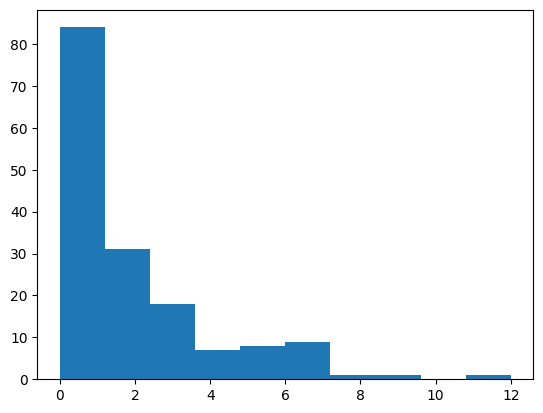

In [90]:
plt.hist(predicted_df['Predicted_shipment'])

In [91]:
predicted_df['Predicted_shipment'].unique()

array([ 4,  3,  6,  2,  5,  7,  1,  9,  0,  8, 12], dtype=int64)

In [92]:
predicted_df['shipment'].unique()

array([ 4,  3,  6,  2,  5,  7,  1,  9,  0,  8, 12], dtype=int64)

In [93]:
#predicted_df[predicted_df['Predicted_shipment']>2][['shipment', 'Predicted_shipment']]
predicted_df[['shipment', 'Predicted_shipment']]

,shipment,Predicted_shipment
0,4,4
1,3,3
2,6,6
3,2,2
4,5,5
5,3,3
6,7,7
7,2,2
8,3,3
9,6,6


In [94]:
import joblib
# Save the model to a file
joblib.dump(model_xgb, 'Xgb_model_V4.joblib')

['Xgb_model_V4.joblib']

In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_df['shipment'], predicted_df['Predicted_shipment'])

1.0